<h3 style="margin-bottom: 1em;"><img src="https://www.proteinmetrics.com/wp-content/uploads/2017/08/logo.svg" width="320" style="display: inline; margin: 0 2em 0 0;" /> Peak Deltas</h3>

In [1]:
import os
import re
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats
from pyteomics import mzml
from IPython.display import HTML, Markdown, display_html
from scipy.optimize import curve_fit

In [2]:
# global settings and variables
pd.set_option('display.float_format', lambda x: '%.4f' % x)
connections = {}

In [3]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)



def fetch_peaks_from_byspec2(byspec2_path, offset=0, limit=1000):
    global connections
    if byspec2_path not in connections:
        connections[byspec2_path] = sqlite3.connect(byspec2_path)
        
    conn   = connections[byspec2_path]
    query  = "SELECT s.Id, s.RetentionTime, s.ScanNumber, s.NativeId, p.PeaksMz, p.PeaksIntensity " + \
             "FROM Spectra AS s JOIN Peaks AS p ON (s.PeaksId = p.Id)" + \
             "WHERE (s.MSLevel = 1) AND (p.PeaksCount > 0) " + \
             "LIMIT {},{}".format(offset, limit)
    return conn.execute(query).fetchall()

In [4]:
def get_scans(byspec2_path, offset, limit):
    result = fetch_peaks_from_byspec2(byspec2_path, offset, limit)
    return [
        {
            'id':       row[0],
            'rt':       row[1],
            'number':   row[2],
            'nativeId': row[3],
            'mz':       np.frombuffer(row[4], dtype=np.float64),
            'intens':   np.frombuffer(row[5], dtype=np.float32)
        }
        for row in result
    ]

--- 
### Peak-Delta Metric

In [5]:
full_centroid_mode_byspec2_filename = './cdifficile.centroid_const_01_fullgauss.byspec2'
middle_sigma_centroid_mode_byspec2_filename = './cdifficile.centroid_const_01.byspec2'

#if 'BYSPEC2_FILE' in os.environ:
#    display('WARNING: using BYSPEC2_FILE set through env var:', os.environ['BYSPEC2_FILE'])
#    centroid_mode_byspec2_filename = os.environ['BYSPEC2_FILE']

In [6]:
offset = int(os.environ.get('BYSPEC2_OFFSET', '2000'))
limit  = int(os.environ.get('BYSPEC2_LIMIT',  '1000'))
full_scans  = get_scans(full_centroid_mode_byspec2_filename, offset, limit)
mids_scans  = get_scans(middle_sigma_centroid_mode_byspec2_filename, offset, limit)
#display('Sample full gaussian scan:', full_scans[len(full_scans) // 2])
display('Sample full gaussian scan:', full_scans[len(full_scans) // 2]['id'])
#display('Sample middle sigma scan:', mids_scans[len(mids_scans) // 2])
display('Sample middle sigma scan:', mids_scans[len(mids_scans) // 2]['id'])

'Sample full gaussian scan:'

2506

'Sample middle sigma scan:'

2506

In [7]:
# visually check the dataset by plotting the profile-mode spectra
#fig, ax = plt.subplots(1, 1, figsize=(16,5))
#fscan = full_scans[len(full_scans) // 2]
#ax.stem(fscan['mz'], fscan['intens'], use_line_collection=True, linefmt='b-', markerfmt=' ');
# ax.set_xlim(915, 918)
#display(Markdown('#### Check spectra - Full Gaussian Scan #{}'.format(fscan['id'])))

In [8]:
def build_diff_dataframe(scans, NDIFFS=4, MAXDIFF=3.0):
    def _mzdiff(mz, i):
        diff = (mz[i:] - mz[:-i])[:mz.size - NDIFFS]
        diff[diff > MAXDIFF] = np.NaN
        return diff 

    def _diff_rowdata(scan):
        return np.stack(
            [np.full((scan['mz'].size - NDIFFS,), scan['id'], dtype=np.int32), scan['mz'][:-NDIFFS]] +
            [_mzdiff(scan['mz'], i) for i in range(1, NDIFFS + 1)],
            axis=1
        )

    data = np.concatenate([
        _diff_rowdata(scan)
        for scan in scans
        if scan['mz'].size >= NDIFFS
    ], axis=0)
    columns = np.array(['scan id', 'mz'] + ['diff{:02d}'.format(i) for i in range(1, NDIFFS + 1)])

    df = pd.DataFrame(columns=columns, data=data)
    df['scan id'] = df['scan id'].astype('int32')
    return df

fdf = build_diff_dataframe(full_scans)
mdf = build_diff_dataframe(mids_scans)
display('Full Gaussian / Middle Sigma Gaussian centroiding')

display_side_by_side(fdf.describe(), mdf.describe())
# display(fdf.describe())
# display(mdf.describe())

#display_side_by_side(fdf.sample(4), mdf.sample(4))
#display(fdf.sample(4))
#display(mdf.sample(4))


'Full Gaussian / Middle Sigma Gaussian centroiding'

scan id 
 mz 
 diff01 
 diff02 
 diff03 
 diff04 
 
 
 
 
 count 
 996000.0000 
 996000.0000 
 956420.0000 
 912727.0000 
 867667.0000 
 818711.0000 
 
 
 mean 
 2654.1300 
 488.9288 
 0.4223 
 0.7500 
 1.0320 
 1.2800 
 
 
 std 
 490.1254 
 154.7918 
 0.4738 
 0.5690 
 0.6171 
 0.6426 
 
 
 min 
 2001.0000 
 299.9995 
 0.0055 
 0.0162 
 0.0270 
 0.0383 
 
 
 25% 
 2250.7500 
 378.6524 
 0.0780 
 0.3350 
 0.5867 
 0.8593 
 
 
 50% 
 2505.5000 
 458.7883 
 0.2879 
 0.6215 
 0.9610 
 1.0920 
 
 
 75% 
 3031.5000 
 549.2614 
 0.5291 
 0.9922 
 1.3430 
 1.6917 
 
 
 max 
 3793.0000 
 1247.8838 
 3.0000 
 3.0000 
 3.0000 
 3.0000 
 
 
 
 
 
 
 scan id 
 mz 
 diff01 
 diff02 
 diff03 
 diff04 
 
 
 
 
 count 
 995979.0000 
 995979.0000 
 953722.0000 
 905679.0000 
 857387.0000 
 806733.0000 
 
 
 mean 
 2654.1152 
 492.1037 
 0.4286 
 0.7511 
 1.0263 
 1.2686 
 
 
 std 
 490.1166 
 160.2139 
 0.4930 
 0.5855 
 0.6290 
 0.6511 
 
 
 min 
 2001.0000 
 299.9995 
 0.0001 
 0.0103 
 0.0206 
 0.0326 
 
 
 25% 
 2250.0000 
 378.5174 
 0.0744 
 0.3315 
 0.5654 
 0.8338 
 
 
 50% 
 2505.0000 
 458.8630 
 0.2849 
 0.6107 
 0.9555 
 1.0799 
 
 
 75% 
 3031.0000 
 551.2404 
 0.5360 
 0.9938 
 1.3442 
 1.6836 
 
 
 max 
 3793.0000 
 1248.9038 
 3.0000 
 3.0000 
 3.0000 
 3.0000

In [9]:
EXPECTED_MZ_DIFFS = np.array([(1 / x) for x in range(1, 13)])
def plot_mzdiff_hist(series, nbins=25, logscale=False, ax=None, title=None):
    ax   = series.hist(bins=nbins, ax=ax, figsize=(None if ax else (16, 4)))
    ymax = ax.get_ylim()[1]
    ax.stem(EXPECTED_MZ_DIFFS, np.full(EXPECTED_MZ_DIFFS.size, ymax),
            use_line_collection=True, linefmt='b-', markerfmt=' ');
    ax.set_xlim(0, 2.1)
    ax.set_title(title)
    if logscale:
        plt.yscale('log', nonposy='clip');

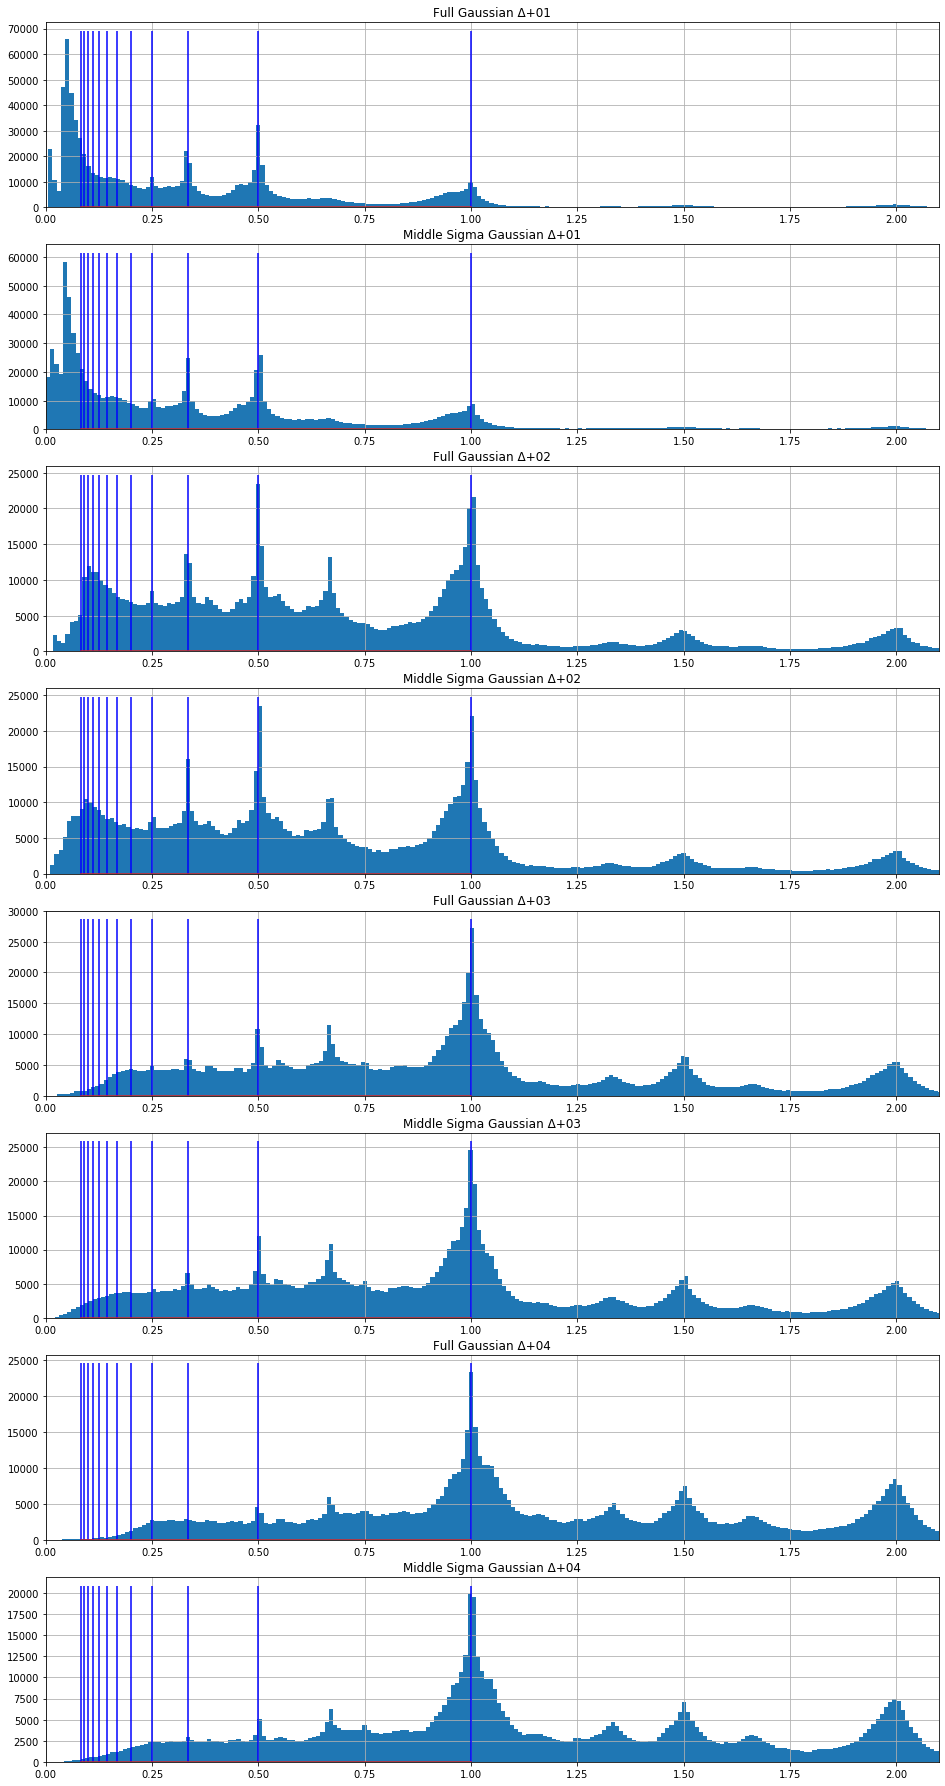

In [10]:
fdiff_cols = [col for col in fdf.columns if col.startswith('diff')]
mdiff_cols = [col for col in mdf.columns if col.startswith('diff')]

fig, axes = plt.subplots(len(fdiff_cols) + len(mdiff_cols), 1, figsize=(16, 4 * (len(fdiff_cols) + len(mdiff_cols)))) 
axes = list(axes)

for fcol, mcol in zip(fdiff_cols, mdiff_cols):
    plot_mzdiff_hist(fdf[fcol], nbins=300, logscale=False, ax=axes.pop(0),
                     title='Full Gaussian Δ+{}'.format(fcol[-2:]))
    plot_mzdiff_hist(mdf[mcol], nbins=300, logscale=False, ax=axes.pop(0),
                     title='Middle Sigma Gaussian Δ+{}'.format(mcol[-2:]))                                                                            
                                                                                 

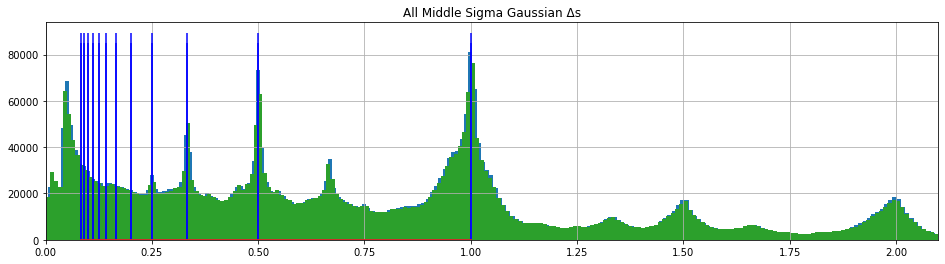

In [11]:
alldiff_fdf = pd.DataFrame(
    data=np.concatenate([fdf[col] for col in fdf.columns if col.startswith('diff')]),
    columns=['diff']
)
plot_mzdiff_hist(alldiff_fdf['diff'], nbins=300, title='All Full Gaussian Δs')

alldiff_mdf = pd.DataFrame(
    data=np.concatenate([mdf[col] for col in mdf.columns if col.startswith('diff')]),
    columns=['diff']
)
plot_mzdiff_hist(alldiff_mdf['diff'], nbins=300, title='All Middle Sigma Gaussian Δs')

In [12]:
def display_mzdiff_stats(fseries, mseries, ftitle, mtitle, in_range_percentage=10.0):
    def _points_in_range(series, ref_value):
        abs_range = (ref_value * in_range_percentage / 100.0)
        return series[abs(series - ref_value) < abs_range]
    
    def _stats(series, expected_diff):
        nearby_points = _points_in_range(series, expected_diff)
        return [
            expected_diff, nearby_points.count(), nearby_points.std(),
            scipy.stats.variation(nearby_points.values, nan_policy='omit')
        ]
    
    fdata = [ _stats(fseries, expected_diff) for expected_diff in EXPECTED_MZ_DIFFS ]
    mdata = [ _stats(mseries, expected_diff) for expected_diff in EXPECTED_MZ_DIFFS ]
    fstatsdf = pd.DataFrame(columns=['expected m/z diff', 'count', 'stddev', 'variation'], data=fdata)
    mstatsdf = pd.DataFrame(columns=['expected m/z diff', 'count', 'stddev', 'variation'], data=mdata)
    
    display(HTML('<h4>{}   ---     {}</h4>'.format(ftitle, mtitle)))
    display_side_by_side(fstatsdf, mstatsdf)
    
    fexpected = 100.0 * fstatsdf['count'].sum() / fseries.size
    mexpected = 100.0 * mstatsdf['count'].sum() / mseries.size    
    display(HTML('<span># points within {}% of expected diffs: </span>: <b>{} - {}  ({:.2f}%) - ({:.2f}%)</b>'.format(
        in_range_percentage, fstatsdf['count'].sum(), mstatsdf['count'].sum(), fexpected, mexpected)))
    

In [13]:
ftitle='Full Gaussian Nearest neighbor (mz[n+1] - mz[n])'
mtitle='Middle Sigma Nearest neighbor (mz[n+1] - mz[n])'
display_mzdiff_stats(fdf['diff01'], mdf['diff01'], ftitle, mtitle)

ftitle='Full Gaussian Nearest neighbor (mz[n+2] - mz[n])'
mtitle='Middle Sigma Nearest neighbor (mz[n+2] - mz[n])'
display_mzdiff_stats(fdf['diff02'], mdf['diff02'], ftitle, mtitle)

ftitle='Full Gaussian All neighbors ((n+1), (n+2), ... (n+4)'
mtitle='Middle Sigma All neighbors ((n+1), (n+2), ... (n+4)'

display_mzdiff_stats(alldiff_fdf['diff'], alldiff_mdf['diff'], ftitle, mtitle)


expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 85992 
 0.0427 
 0.0435 
 
 
 1 
 0.5000 
 118028 
 0.0229 
 0.0460 
 
 
 2 
 0.3333 
 77884 
 0.0156 
 0.0470 
 
 
 3 
 0.2500 
 42793 
 0.0134 
 0.0536 
 
 
 4 
 0.2000 
 36142 
 0.0115 
 0.0580 
 
 
 5 
 0.1667 
 38051 
 0.0096 
 0.0579 
 
 
 6 
 0.1429 
 33318 
 0.0083 
 0.0580 
 
 
 7 
 0.1250 
 31112 
 0.0072 
 0.0576 
 
 
 8 
 0.1111 
 30504 
 0.0064 
 0.0581 
 
 
 9 
 0.1000 
 33153 
 0.0058 
 0.0581 
 
 
 10 
 0.0909 
 37310 
 0.0052 
 0.0577 
 
 
 11 
 0.0833 
 42048 
 0.0048 
 0.0581 
 
 
 
 
 
 
 expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 81076 
 0.0433 
 0.0441 
 
 
 1 
 0.5000 
 111239 
 0.0231 
 0.0465 
 
 
 2 
 0.3333 
 76613 
 0.0158 
 0.0477 
 
 
 3 
 0.2500 
 43189 
 0.0135 
 0.0541 
 
 
 4 
 0.2000 
 36397 
 0.0115 
 0.0579 
 
 
 5 
 0.1667 
 37449 
 0.0096 
 0.0578 
 
 
 6 
 0.1429 
 32555 
 0.0083 
 0.0579 
 
 
 7 
 0.1250 
 29865 
 0.0072 
 0.0576 
 
 
 8 
 0.1111 
 29233 
 0.0064 
 0.0579 
 
 
 9 
 0.1000 
 31107 
 0.0058 
 0.0581 
 
 
 10 
 0.0909 
 33862 
 0.0052 
 0.0578 
 
 
 11 
 0.0833 
 36957 
 0.0048 
 0.0582

expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 178578 
 0.0432 
 0.0437 
 
 
 1 
 0.5000 
 103318 
 0.0250 
 0.0499 
 
 
 2 
 0.3333 
 59687 
 0.0171 
 0.0511 
 
 
 3 
 0.2500 
 35198 
 0.0140 
 0.0560 
 
 
 4 
 0.2000 
 27783 
 0.0116 
 0.0579 
 
 
 5 
 0.1667 
 26527 
 0.0097 
 0.0582 
 
 
 6 
 0.1429 
 26628 
 0.0083 
 0.0584 
 
 
 7 
 0.1250 
 26505 
 0.0071 
 0.0572 
 
 
 8 
 0.1111 
 25356 
 0.0064 
 0.0581 
 
 
 9 
 0.1000 
 23374 
 0.0057 
 0.0570 
 
 
 10 
 0.0909 
 18013 
 0.0049 
 0.0538 
 
 
 11 
 0.0833 
 11298 
 0.0046 
 0.0545 
 
 
 
 
 
 
 expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 166622 
 0.0438 
 0.0443 
 
 
 1 
 0.5000 
 103956 
 0.0250 
 0.0499 
 
 
 2 
 0.3333 
 59790 
 0.0172 
 0.0515 
 
 
 3 
 0.2500 
 34016 
 0.0140 
 0.0558 
 
 
 4 
 0.2000 
 26157 
 0.0116 
 0.0579 
 
 
 5 
 0.1667 
 24201 
 0.0096 
 0.0580 
 
 
 6 
 0.1429 
 22795 
 0.0083 
 0.0584 
 
 
 7 
 0.1250 
 22235 
 0.0072 
 0.0574 
 
 
 8 
 0.1111 
 21191 
 0.0064 
 0.0580 
 
 
 9 
 0.1000 
 20485 
 0.0058 
 0.0576 
 
 
 10 
 0.0909 
 18015 
 0.0051 
 0.0565 
 
 
 11 
 0.0833 
 14982 
 0.0049 
 0.0583

expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 672018 
 0.0458 
 0.0461 
 
 
 1 
 0.5000 
 306547 
 0.0248 
 0.0497 
 
 
 2 
 0.3333 
 187231 
 0.0169 
 0.0507 
 
 
 3 
 0.2500 
 111862 
 0.0138 
 0.0552 
 
 
 4 
 0.2000 
 85603 
 0.0115 
 0.0578 
 
 
 5 
 0.1667 
 78782 
 0.0096 
 0.0580 
 
 
 6 
 0.1429 
 68587 
 0.0083 
 0.0581 
 
 
 7 
 0.1250 
 62630 
 0.0072 
 0.0575 
 
 
 8 
 0.1111 
 59342 
 0.0064 
 0.0581 
 
 
 9 
 0.1000 
 58890 
 0.0058 
 0.0577 
 
 
 10 
 0.0909 
 56999 
 0.0052 
 0.0572 
 
 
 11 
 0.0833 
 54750 
 0.0049 
 0.0585 
 
 
 
 
 
 
 expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 638003 
 0.0458 
 0.0461 
 
 
 1 
 0.5000 
 304348 
 0.0249 
 0.0499 
 
 
 2 
 0.3333 
 184738 
 0.0170 
 0.0510 
 
 
 3 
 0.2500 
 107954 
 0.0138 
 0.0553 
 
 
 4 
 0.2000 
 84268 
 0.0115 
 0.0577 
 
 
 5 
 0.1667 
 77690 
 0.0096 
 0.0579 
 
 
 6 
 0.1429 
 67264 
 0.0083 
 0.0580 
 
 
 7 
 0.1250 
 61157 
 0.0072 
 0.0575 
 
 
 8 
 0.1111 
 57545 
 0.0064 
 0.0579 
 
 
 9 
 0.1000 
 57233 
 0.0058 
 0.0580 
 
 
 10 
 0.0909 
 56273 
 0.0052 
 0.0575 
 
 
 11 
 0.0833 
 55535 
 0.0049 
 0.0585